In [2]:
# pip install --upgrade tensorflow

In [3]:
# pip install tensorflow-text

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics.pairwise import cosine_similarity


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
path = "/kaggle/input/ham-spam-dataset/spam.csv"

In [6]:
df = pd.read_csv(path)

In [7]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'],
      dtype='object')

In [9]:
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'], axis = 1)

In [10]:
df.shape

(5572, 2)

In [11]:
df = df.rename(columns={'v1': 'Category', 'v2': 'Message'})
df.head()

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [12]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    653  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [13]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

In [14]:
df_spam = df[df['Category'] == 'spam']
df_spam.shape

(747, 2)

In [15]:
df_ham = df[df['Category'] == 'ham']
df_ham.shape

(4825, 2)

In [16]:
df_ham.sample(2)

,Category,Message
3404,ham,"Jus chillaxin, what up"
1830,ham,That's the way you should stay oh.


In [17]:
df_ham_downsample = df_ham.sample(len(df_spam))
df_ham_downsample.shape

(747, 2)

In [18]:
df_balanced = pd.concat([df_spam, df_ham_downsample])
df_balanced.shape

(1494, 2)

In [19]:
df_balanced['Category'].value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

In [20]:
df_balanced.sample(5)

,Category,Message
1186,ham,"Goodmorning, Today i am late for &lt;#&gt; min."
4699,spam,WIN: We have a winner! Mr. T. Foley won an iPo...
2969,ham,U should make a fb list
167,ham,"Hi frnd, which is best way to avoid missunders..."
2952,spam,"URGENT! Your mobile was awarded a �1,500 Bonus..."


In [21]:
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x =='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
2611,spam,Knock Knock Txt whose there to 80082 to enter ...,1
4600,spam,FreeMsg: Txt: CALL to No: 86888 & claim your r...,1
3846,spam,Fantasy Football is back on your TV. Go to Sky...,1
4706,ham,Wif my family booking tour package.,0
5452,ham,What???? Hello wats talks email address?,0


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify=df_balanced['spam'])

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [23]:
X_train.head(5)

210     What's up bruv, hope you had a great break. Do...
3550                              I love you both too :-)
17      Eh u remember how 2 spell his name... Yes i di...
3158         Are you up for the challenge? I know i am :)
5237    Someonone you know is trying to contact you vi...
Name: Message, dtype: object

In [24]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [25]:
def get_sentence_embeddings(sentences):
  preprocessed_text = bert_preprocess(sentences)
  return bert_encoder(preprocessed_text)['pooled_output']


In [26]:
e = get_sentence_embeddings([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates",
    "cow"
]
)

cosine_similarity([e[6]], [e[3]])

array([[0.76160055]], dtype=float32)

In [27]:
sentences = ["Lalon fair is in August.", "Lalon didn't receive fair treatment."]
embeddings = get_sentence_embeddings(sentences)

cosine_similarity = cosine_similarity([embeddings[0]], [embeddings[1]])
print(cosine_similarity)

[[0.97603124]]


In [28]:
e

<tf.Tensor: shape=(7, 768), dtype=float32, numpy=
array([[-0.7606917 , -0.14219393,  0.4960462 , ...,  0.42165324,
        -0.532214  ,  0.8031217 ],
       [-0.86023223, -0.21242943,  0.49156877, ...,  0.39798015,
        -0.60506296,  0.8447165 ],
       [-0.712886  , -0.15463887,  0.3840176 , ...,  0.35278794,
        -0.5099132 ,  0.73474073],
       ...,
       [-0.75041294, -0.26812574, -0.266895  , ...,  0.02839473,
        -0.5938095 ,  0.7974982 ],
       [-0.7854436 , -0.2994969 ,  0.41027337, ...,  0.52225375,
        -0.49573565,  0.8150751 ],
       [-0.7610192 , -0.14340702,  0.73569256, ...,  0.60526794,
        -0.5229588 ,  0.77946174]], dtype=float32)>

In [29]:
#bert layers
text_input = tf.keras.layers.Input(shape = (), dtype = tf.string, name = 'text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#NN layers
layer = tf.keras.layers.Dropout(0.1, name = 'dropout')(outputs['pooled_output'])
layer = tf.keras.layers.Dense(1, activation = 'sigmoid', name = 'output')(layer)

#construct final model
model = tf.keras.Model(inputs = [text_input], outputs = [layer])


In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_type_ids': (None,                                            
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             }                                                                

In [31]:
METRICS = [
    tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
    tf.keras.metrics.Precision(name = 'precision'),
    tf.keras.metrics.Recall(name = 'recall')
]

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = METRICS)


In [32]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  2


In [33]:
model.fit(X_train, y_train, epochs = 20)

Epoch 1/20
35/35 [==============================] - 21s 303ms/step - loss: 0.6506 - accuracy: 0.6045 - precision: 0.6035 - recall: 0.6089
Epoch 2/20
35/35 [==============================] - 11s 305ms/step - loss: 0.5158 - accuracy: 0.7875 - precision: 0.7785 - recall: 0.8036
Epoch 3/20
35/35 [==============================] - 11s 306ms/step - loss: 0.4521 - accuracy: 0.8411 - precision: 0.8162 - recall: 0.8804
Epoch 4/20
35/35 [==============================] - 11s 307ms/step - loss: 0.4028 - accuracy: 0.8696 - precision: 0.8581 - recall: 0.8857
Epoch 5/20
35/35 [==============================] - 11s 311ms/step - loss: 0.3722 - accuracy: 0.8786 - precision: 0.8605 - recall: 0.9036
Epoch 6/20
35/35 [==============================] - 11s 313ms/step - loss: 0.3494 - accuracy: 0.8821 - precision: 0.8715 - recall: 0.8964
Epoch 7/20
35/35 [==============================] - 11s 317ms/step - loss: 0.3351 - accuracy: 0.8929 - precision: 0.8887 - recall: 0.8982
Epoch 8/20
35/35 [================

In [34]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 5s 315ms/step - loss: 0.2057 - accuracy: 0.9412 - precision: 0.9508 - recall: 0.9305


[0.20574328303337097,
 0.9411764740943909,
 0.9508196711540222,
 0.9304812550544739]

In [35]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

12/12 [==============================] - 4s 320ms/step


In [36]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,

In [37]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

array([[178,   9],
       [ 13, 174]])

Text(50.722222222222214, 0.5, 'Truth')

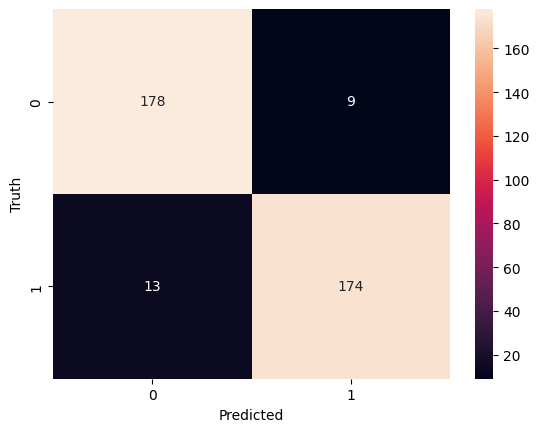

In [38]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [39]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       187
           1       0.95      0.93      0.94       187

    accuracy                           0.94       374
   macro avg       0.94      0.94      0.94       374
weighted avg       0.94      0.94      0.94       374



/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

In [58]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until December 31, 2023',
    'Hi dear, Your CV has passed, please reply to this email and receive a salary of 2000 Taka per day.',
    'Dear, you have successfully passed the interview. Reply to me immediately and you can receive 2000 BDT per day.',
    'Hey Noman, Are you coming for a cricket game tomorrow',
    'Hi dear, Your CV has passed, please reply to this email and receive a salary of 2000 Taka per day.'

model_output = model.predict(reviews)

model_output = np.where(model_output > 0.5, 'Spam', 'Not-Spam')

print(model_output)

1/1 [==============================] - 0s 47ms/step
[['Spam']
 ['Spam']
 ['Spam']
 ['Not-Spam']
 ['Spam']]


In [61]:
reviews = [
    'Hi dear, Your CV has passed, please reply to this email and receive a salary of 2000 Taka per day.', 
    'Dear, your resume has been selected. Very lucky to get 2000TK, please reply to this email.'
]
model_output = model.predict(reviews)

model_output = np.where(model_output > 0.5, 'Spam', 'Not-Spam')

print(model_output)

1/1 [==============================] - 0s 43ms/step
[['Spam']
 ['Spam']]


In [64]:
reviews = ['I hope this text finds you well. As part of our ongoing commitment to employee development and growth, we would like to schedule a performance review meeting with you.']

model_output = model.predict(reviews)

model_output = np.where(model_output > 0.5, 'Spam', 'Not-Spam')

print(model_output)

1/1 [==============================] - 0s 42ms/step
[['Not-Spam']]
